In [1]:
import torch
import nrrd

import numpy as np

import matplotlib.pyplot as plt

In [2]:
from bts.mmformer.mmformer.mmformer import Model

class_num = 4
mmformer = Model(num_cls=class_num)
mmformer_woft = torch.nn.DataParallel(mmformer).cuda()

weights_path = "/home/desmin/grad_project/bbm47980_bts/bts/mmformer/mmformer/out/model_last.pth"
mmformer_woft.load_state_dict(torch.load(weights_path)["state_dict"])

<All keys matched successfully>

In [3]:
from bts.mmformer.mmformer.mmformer import Model

weights_path = "/home/desmin/grad_project/bbm47980_bts/notebooks/mmformer_model_weights.pth"
class_num = 4

mmformer = Model(num_cls=class_num)
mmformer.load_state_dict(torch.load(weights_path))
mmformer_wft = torch.nn.DataParallel(mmformer).cuda()

In [4]:
def test_model(
    im_path : str,
    label_path : str,
    model : torch.nn.Module
):
    model.eval()
    
    img, _ = nrrd.read(im_path)
    label = np.load(label_path)
    
    H, W, Z = img.shape
    t1ce_channel = 1
    patch_size = 128
    class_num = 2
    
    batch = np.zeros((1, 4, H, W, Z), dtype=np.float32)
    batch[:,t1ce_channel] = img

    batch = torch.from_numpy(batch)
    
    one_tensor = torch.ones(1, patch_size, patch_size, patch_size).float().cuda()

    h_cnt = int(np.ceil((H - patch_size) / (patch_size * (1 - 0.5))))
    h_idx_list = range(0, h_cnt)
    h_idx_list = [h_idx * int(patch_size * (1 - 0.5)) for h_idx in h_idx_list]
    h_idx_list.append(H - patch_size)

    w_cnt = int(np.ceil((W - patch_size) / (patch_size * (1 - 0.5))))
    w_idx_list = range(0, w_cnt)
    w_idx_list = [w_idx * int(patch_size * (1 - 0.5)) for w_idx in w_idx_list]
    w_idx_list.append(W - patch_size)

    z_cnt = int(np.ceil((Z - patch_size) / (patch_size * (1 - 0.5))))
    z_idx_list = range(0, z_cnt)
    z_idx_list = [z_idx * int(patch_size * (1 - 0.5)) for z_idx in z_idx_list]
    z_idx_list.append(Z - patch_size)

    #####compute calculation times for each pixel in sliding windows
    weight1 = torch.zeros(1, 1, H, W, Z).float().cuda()
    for h in h_idx_list:
        for w in w_idx_list:
            for z in z_idx_list:
                weight1[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size] += one_tensor
    weight = weight1.repeat(1, class_num, 1, 1, 1)
    
    feature_mask = [False, True, False, False] # only include T2
    mask = torch.from_numpy(np.array(feature_mask))
    mask = torch.unsqueeze(mask, dim=0).repeat(1, 1)
    
    with torch.no_grad():
        batch = batch.cuda()
        mask = mask.cuda()

        pred = torch.zeros(1, class_num, H, W, Z).float().cuda()
        model.module.is_training=False
        for h in h_idx_list:
            for w in w_idx_list:
                for z in z_idx_list:
                    batch_i = batch[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size]
                    pred_part = model(batch_i, mask)
                    
                    fuse_pred_tumour, _ = torch.max(pred_part[:,1:], dim=1)
                    fuse_pred_background = pred_part[:,0]

                    pred_part = torch.stack([fuse_pred_background, fuse_pred_tumour], dim=1)
                    
                    pred[:, :, h:h+patch_size, w:w+patch_size, z:z+patch_size] += pred_part
        pred = pred / weight
        pred = pred[:, :, :H, :W, :Z]
        pred = torch.argmax(pred, dim=1)
        
    return img, pred[0].cpu().numpy(), label

In [19]:
im_path = "/home/desmin/data/porcupine_dataset/train/129/image.nrrd"
label_path = "/home/desmin/data/porcupine_dataset/train/129/transform_label.npy"

img, pred_wofn, label = test_model(im_path, label_path, mmformer_woft)
img, pred_wfn, label = test_model(im_path, label_path, mmformer_wft)

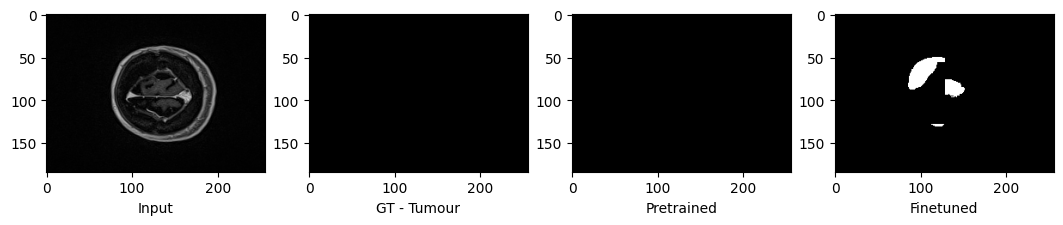

In [25]:
fig, axs = plt.subplots(1,4,figsize=(13,6), dpi=100)
slice_idx = 150
axs[0].imshow(img[...,slice_idx], cmap='gray')
axs[0].set_xlabel("Input")
axs[1].imshow(label[...,slice_idx]==2, cmap='gray')
axs[1].set_xlabel("GT - Tumour")
axs[2].imshow(pred_wofn[...,slice_idx], cmap='gray')
axs[2].set_xlabel("Pretrained")
axs[3].imshow(pred_wfn[...,slice_idx], cmap='gray')
axs[3].set_xlabel("Finetuned")
plt.show()

In [16]:
label.dtype

dtype('uint8')

In [18]:
nrrd.write("/home/desmin/data/mmformer_infers/169_image.nrrd", img)
nrrd.write("/home/desmin/data/mmformer_infers/169_label.nrrd", label)
nrrd.write("/home/desmin/data/mmformer_infers/169_pred_woft.nrrd", pred_wofn.astype(np.uint8))   
nrrd.write("/home/desmin/data/mmformer_infers/169_pred_wft.nrrd", pred_wfn.astype(np.uint8)) 